In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import KL, evaluate_metrics

from Experiments import get_setup

from Inference.IVI import IVI

from tqdm import trange

import timeit

In [3]:
#hyperparameters

#predictive model
layerwidth=50
nblayers=1
activation=nn.Tanh()





#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=500 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour



In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")

In [5]:
def sKL(theta0, theta1, k=1, device='cpu', p=2):
    """
        Parameters:
            theta0 (Tensor): Samples, P X NbDimensions
            theta1 (Tensor): Samples, R X NbDimensions
            k (Int): positive ordinal number

        Returns:
            (Float) k-Nearest Neighbour Estimation of the KL from theta0 to theta1

        """

    n0 = theta0.shape[0]
    n1 = theta1.shape[0]
    dim0 = theta0.shape[1]
    dim1 = theta1.shape[1]
    assert dim0 == dim1

    D0 = torch.cdist(theta0, theta0, p=p)
    D1 = torch.cdist(theta0, theta1, p=p)
    C0 =torch.cdist(theta1, theta1, p=p)
    a0 = torch.topk(D0, k=k + 1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf')).to(device)
    a1 = torch.topk(D1, k=k, dim=1, largest=False, sorted=True)[0][:,k - 1]  # .clamp(torch.finfo().eps,float('inf')).to(device)
    b0 = torch.topk(D1, k=k, dim=0, largest=False, sorted=True)[0][k - 1,:]  # .clamp(torch.finfo().eps,float('inf')).to(device)
    b1 = torch.topk(C0, k=k+1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf')).to(device)

    assert a0.shape == a1.shape, 'dimension do not match'

    d = torch.as_tensor(float(dim0), device=device)
    N0 = torch.as_tensor(float(n0), device=device)
    N1 = torch.as_tensor(float(n1), device=device)

    Mnn = torch.log(a1).mean() - torch.log(a0).mean()+torch.log(b0).mean()-torch.log(b1).mean()
    return d * Mnn 
theta=torch.randn(1000,100)
theta_=2*torch.randn(1000,100)
sKL(theta,theta_, k=1)

tensor(25.9902)

# Setup #

In [6]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='foong' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

sigma_noise=setup.sigma_noise
print(sigma_noise)
sigma_prior=1.#setup.sigma_prior    

size_data=len(train_dataset)
#batch_size
batch_size=30


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

0.1


# Predictive model #

In [7]:
input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

print('input dim: '+str(input_dim))
print('param count: '+str(param_count))

#prior on parameters of predictive model

X=torch.linspace(-2.,2.,100).to(device)


input dim: 1
param count: 151


3.7386157512664795 1.8623565435409546


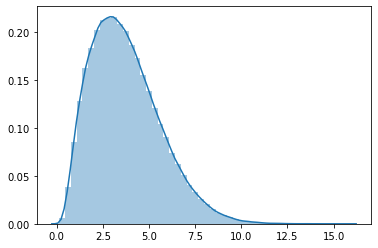

In [8]:

theta_prior=torch.randn((1000,param_count)).to(device)
dist_theta_prior=torch.pdist(theta_prior)
f_=model(X,theta_prior)
dist_f_=torch.pdist(f_.squeeze())#/torch.tensor(float(len(X))).sqrt()
ratios_=(dist_f_/dist_theta_prior)

import seaborn as sns

sns.distplot(ratios_.detach().cpu())
print(ratios_.mean().item(),ratios_.std().item())


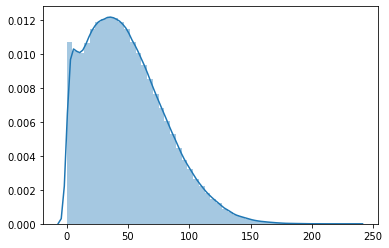

In [9]:

theta_prior=torch.randn((1000,param_count)).to(device)
dist_theta_prior=torch.pdist(theta_prior)
f_=model(X,theta_prior)
dist_f_=torch.pdist(f_.squeeze())#/torch.tensor(float(len(X))).sqrt()
deltas_=(dist_f_-dist_theta_prior).abs()
import seaborn as sns
sns.distplot(deltas_.detach().cpu())

In [10]:
class Transformer(nn.Module):
    def __init__(self, lat_dim, output_dim, device):
        super(Transformer, self).__init__()
        
        self.lat_dim = lat_dim
        self.device=device
        self.output_dim=output_dim
        
        
        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.ReLU(inplace=True))#nn.LeakyReLU(inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(lat_dim, 2*lat_dim),
     #       *block(2*lat_dim, 4*lat_dim),
            nn.Linear(2*lat_dim, output_dim)
        )
      
        
   
    def forward(self, epsilon):
        return self.model(epsilon) 

def input_sampler(n):
    M = 2.#x_train.max(0, keepdim=True)[0]+epsilon
    m = -2.#x_train.min(0, keepdim=True)[0]-epsilon
    return torch.rand(n,input_dim).to(device) * (M-m) + m   

lat_dim=100
T = Transformer(lat_dim,param_count,device).to(device)
log_S=torch.tensor(0.).requires_grad_(True)
optimizer = torch.optim.Adam(list(T.parameters())+[log_S], lr=0.005)

def prior_lat(n):
    return torch.randn((n,lat_dim)).to(device)

def prior_param(n):
    return torch.randn((n,param_count)).to(device)


torch.Size([1000, 100])


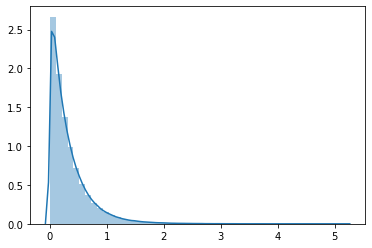

In [11]:
theta_lat=prior_lat(1000)
print(theta_lat.shape)
dist_theta=torch.pdist(theta_lat).pow(2)
#    norm_theta=torch.norm(theta_lat)
theta=T(theta_lat)
f=model(X,theta)
dist_f=torch.pdist(f.squeeze()).pow(2)#/torch.tensor(float(len(X))).sqrt()
#    norm_f=torch.norm(f.squeeze())/torch.tensor(float(len(X))).sqrt()
ratios=(dist_f/dist_theta)
import seaborn as sns
sns.distplot(ratios.detach().cpu())


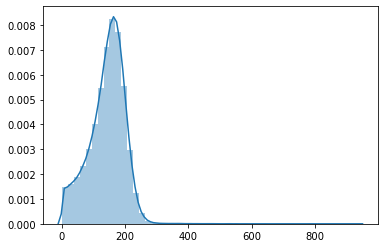

In [12]:

deltas=(dist_theta-dist_f).abs()
sns.distplot(deltas.detach().cpu())

In [13]:
RSTDs=[]
Ks=[]
Ls=[]
Rs=[]
Ss=[]
Errors=[]

In [14]:
from Metrics import Entropy

for param in T.parameters():
    param.requires_grad = True

n_samples=200
with trange(5000) as tr:
    for t in tr:
        optimizer.zero_grad()
        
        X_sample=4*torch.rand((20,1)).to(device)-2.
        theta_lat=prior_lat(n_samples)
        dist_theta=torch.pdist(theta_lat)
    #    norm_theta=torch.norm(theta_lat)
        theta=T(theta_lat)
        f=model(X_sample,theta)
        dist_f=torch.pdist(f.squeeze())#/torch.tensor(float(len(X))).sqrt()
    #    norm_f=torch.norm(f.squeeze())/torch.tensor(float(len(X))).sqrt()
        error=(dist_f/dist_theta).std()
        
        theta_prior=prior_param(n_samples)
        f_prior=model(X_sample,theta_prior)
        K=KL(theta,theta_prior,k=1,device=device)#sKL(f.squeeze(2),f_prior.squeeze(2),k=1,device=device)
        
        NN_dist=torch.cdist(theta,theta_prior).min(dim=0)[0].mean()
        
        L=K+10*error
        L.backward()
        optimizer.step()
        #RSTDs.append(ratios_std.item())
        Ss.append(log_S.exp().item())
        Ks.append(K.item())
        Ls.append(L.item())
        Errors.append(error.item())
        tr.set_postfix(K=K.item(),error=error.item(),NN_dist=NN_dist.item())

100%|██████████| 5000/5000 [00:34<00:00, 144.75it/s, K=-26.6, NN_dist=51.5, error=0.296]


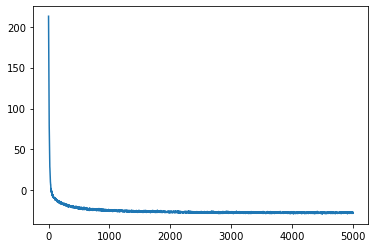

In [15]:
#plt.plot(deltas)
plt.plot(Ks)

0.2962788939476013

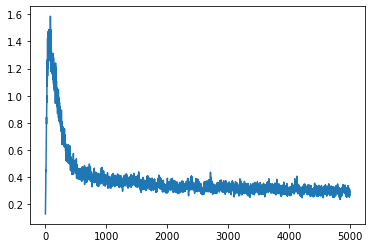

In [16]:
plt.plot(Errors)
#plt.plot(Ks)
#plt.plot(Ls)
Errors[-1]

new: 1.453773856163025±0.6561267375946045
base: 3.800873041152954±1.8853950500488281


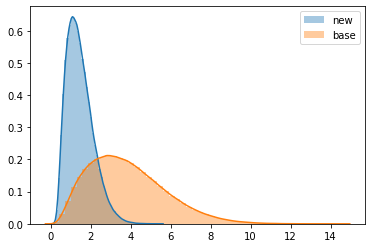

In [17]:
theta_lat=prior_lat(1000)
dist_theta=torch.pdist(theta_lat)
theta=T(theta_lat)
f=model(X,theta)
dist_f=torch.pdist(f.squeeze())#/torch.tensor(float(len(X))).sqrt()
ratios=(dist_f/dist_theta)

theta_prior=prior_param(1000)
dist_theta_prior=torch.pdist(theta_prior)
f_=model(X,theta_prior)
dist_f_=torch.pdist(f_.squeeze())#/torch.tensor(float(len(X))).sqrt()
ratios_=(dist_f_/dist_theta_prior)

import seaborn as sns
sns.distplot(ratios.detach().cpu(),label='new')
sns.distplot(ratios_.detach().cpu(),label='base')
plt.legend()
print('new: {}±{}'.format(ratios.mean().item(),ratios.std().item()))
print('base: {}±{}'.format(ratios_.mean().item(),ratios_.std().item()))


new: 7.120199203491211±5.427364349365234
base: 27.045677185058594±20.369869232177734


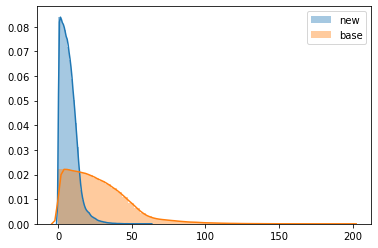

In [18]:
theta_lat=prior_lat(1000)
dist_theta=torch.pdist(theta_lat)
theta=T(theta_lat)#torch.cat([,torch.randn((1000,51),device=device)],dim=1)
f=model(X,theta)
dist_f=torch.pdist(f.squeeze())#/torch.tensor(float(len(X))).sqrt()
S=torch.mean(dist_f/dist_theta)#log_S.exp().item()
deltas=(S*dist_theta-dist_f).abs()

theta_prior=prior_param(1000)
dist_theta_prior=torch.pdist(theta_prior)
f_=model(X,theta_prior)
dist_f_=torch.pdist(f_.squeeze())#/torch.tensor(float(len(X))).sqrt()
deltas_=(ratios_.mean()*dist_theta_prior-dist_f_).abs()
import seaborn as sns
sns.distplot(deltas.detach().cpu(), label='new')
sns.distplot(deltas_.detach().cpu(), label='base')
plt.legend()
print('new: {}±{}'.format(deltas.mean().item(),deltas.std().item()))
print('base: {}±{}'.format(deltas_.mean().item(),deltas_.std().item()))

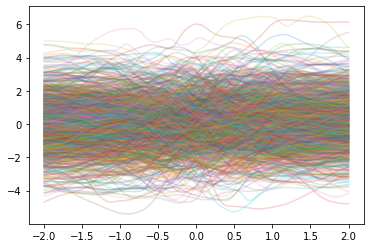

In [19]:
k=1000
theta_lat=prior_lat(k)
theta=T(theta_lat).detach()
y=model(X,theta)
for i in range(k):
    plt.plot(X.cpu(),y[i].cpu(), alpha=0.2)


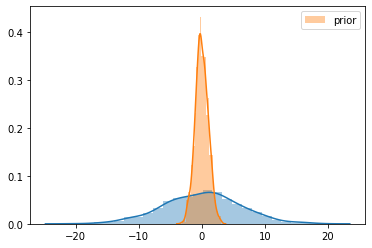

In [20]:
theta_lat=prior_lat(k)
theta=T(theta_lat).detach()
sns.distplot(theta[:,50].cpu())
sns.distplot(torch.randn(1000), label='prior')
plt.legend()

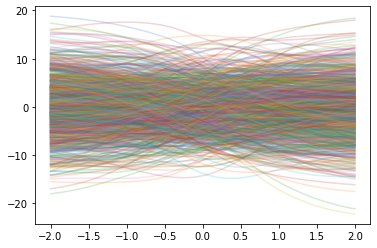

In [21]:
k=1000
theta_prior=prior_param(k)
y=model(X,theta_prior)
for i in range(k):
    plt.plot(X.cpu(),y[i].cpu(), alpha=0.2)


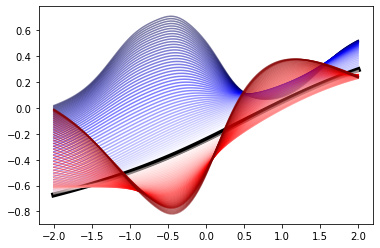

In [24]:
from matplotlib import cm
from matplotlib.colors import Normalize
cmap=plt.get_cmap('seismic')#'viridis')
k=100

a=-2.
b=2.#0000001
norm = Normalize(vmin=a,vmax=b)

i=0
theta_lat=torch.cat([torch.zeros((k,i)).to(device),torch.linspace(a,b,k).view(k,1).to(device),torch.zeros((k,lat_dim-i-1)).to(device)],dim=1)
theta=T(theta_lat)
y=model(X,theta).detach()

middle=k//2

for j in range(k):
    if j == middle:
        plt.plot(X.cpu(),y[j].cpu(), color='black', lw=5.)
    else: 
        plt.plot(X.cpu(),y[j].cpu(), color=cmap(norm(theta_lat[j,i].cpu())),alpha=0.5)



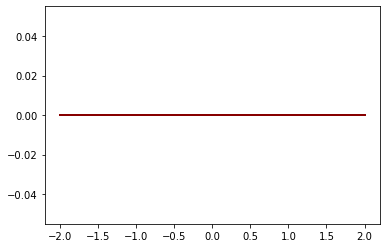

In [25]:
from matplotlib import cm
from matplotlib.colors import Normalize
cmap=plt.get_cmap('seismic')#'viridis')
k=100

a=-2.
b=2.#0000001
norm = Normalize(vmin=a,vmax=b)

#d=F.normalize(torch.randn((1,lat_dim)), p=2, dim=0).to(device)
#t=torch.linspace(a,b,k).view(k,1).to(device)
#theta=t*d
i=50
theta=torch.cat([torch.zeros((k,i)).to(device),torch.linspace(a,b,k).view(k,1).to(device),torch.zeros((k,param_count-i-1)).to(device)],dim=1)
y=model(X,theta)

middle=k//2
plt.plot(X.cpu(),y[middle].cpu(), color='black', lw=2.)

for j in range(k):
    plt.plot(X.cpu(),y[j].cpu(), color=cmap(norm(theta[j,i].cpu())),alpha=0.5)


# ELBO

In [26]:
for param in T.parameters():
    param.requires_grad = False


def prior(n):
    return torch.randn(size=(n,lat_dim), device=device)


## Average Log Likelihood

In [27]:
#average log likelihood loss
def loss(x_data, y_data, GeN):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """

    y_pred=model(x_data,T(GeN(n_samples_LL)))
    log_proba=NormalLogLikelihood(y_pred, y_data, sigma_noise).sum(1)
    return log_proba.mean()

## Kullback-Leibler divergence in Predictor space

In [28]:


def kl(x_data, GeN, beta=1.):

    theta=GeN(n_samples_KL) #variationnel
    theta_prior=prior(n_samples_KL) #prior

    K=KL(theta, theta_prior,k=kNNE,device=device,beta=beta)
    return K



## ELBO ##

In [29]:
#ELBO

beta=1.
def ELBO(x_data, y_data, GeN, beta=beta):
    alpha=(len(x_data)/size_data)
    Average_LogLikelihood=loss(x_data, y_data, GeN)
    the_KL=kl(x_data, GeN, beta)
    the_ELBO= - Average_LogLikelihood+ alpha*the_KL
    return the_ELBO, the_KL, Average_LogLikelihood 


# Generative model #

In [30]:
#generative model
gen_lat_dim=5
GeN = BigGenerator(gen_lat_dim,lat_dim,device).to(device)
print(GeN)

BigGenerator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=100, bias=True)
  )
)


# Optimizer

In [31]:

#optimizer
learning_rate=0.01

#scheduler
patience=100
lr_decay=.5#.7
min_lr= 0.0001
n_epochs=2000#2000


optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)

Run=IVI(train_loader, ELBO, optimizer)

# Scheduler #

In [32]:
#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [33]:
KLs=[]
ELBOs=[]
LLs=[]
LRs=[]

test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[],
              'WAIC':[]
             }
start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        
        theta=GeN(1000).detach()
        y_pred=model(x_test,T(theta))
        metrics=evaluate_metrics(y_pred, torch.tensor(sigma_noise).view(1,1,1), y_test,  std_y_train, device='cpu', std=False)

        for m,v in metrics.items():
            test_metrics[m].append(v)
        
        scores=Run.run(GeN)
        tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'])
        ELBOs.append(scores['ELBO'])
        KLs.append(scores['KL'])
        LLs.append(scores['LL'])
        LRs.append(scores['lr'])
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break
stop = timeit.default_timer()
execution_time = stop - start



 32%|███▎      | 650/2000 [01:17<02:34,  8.73it/s, ELBO=26.5, KL=180, LogLike=18.6, lr=0.005]    

Epoch   649: reducing learning rate of group 0 to 5.0000e-03.


 45%|████▍     | 895/2000 [01:46<02:16,  8.12it/s, ELBO=22.4, KL=166, LogLike=19.2, lr=0.0025]

Epoch   894: reducing learning rate of group 0 to 2.5000e-03.


 60%|██████    | 1202/2000 [02:22<01:30,  8.85it/s, ELBO=18.7, KL=160, LogLike=21.2, lr=0.00125]

Epoch  1201: reducing learning rate of group 0 to 1.2500e-03.


 74%|███████▎  | 1470/2000 [02:53<01:10,  7.57it/s, ELBO=17.5, KL=156, LogLike=21.6, lr=0.000625]

Epoch  1469: reducing learning rate of group 0 to 6.2500e-04.


 84%|████████▍ | 1686/2000 [03:21<00:42,  7.32it/s, ELBO=16.8, KL=156, LogLike=22.1, lr=0.000313]

Epoch  1685: reducing learning rate of group 0 to 3.1250e-04.


 96%|█████████▌| 1919/2000 [03:51<00:09,  8.54it/s, ELBO=15.4, KL=154, LogLike=23, lr=0.000156]  

Epoch  1918: reducing learning rate of group 0 to 1.5625e-04.


100%|██████████| 2000/2000 [04:01<00:00,  8.27it/s, ELBO=16, KL=154, LogLike=22.6, lr=0.000156]  


In [34]:
theta=GeN(1000).detach()
y_pred=model(x_test,T(theta))
metrics=evaluate_metrics(y_pred, torch.tensor(sigma_noise).view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
metrics

{'RMSE': 0.9063975811004639,
 'LPP': -1.2920292615890503,
 'WAIC': -2680.982458949089,
 'PICP': 0.7083333134651184,
 'MPIW': 1.3207412958145142}

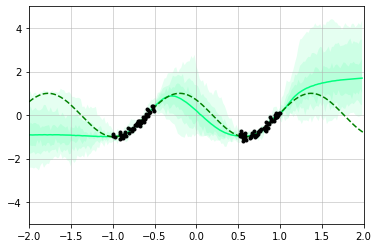

In [35]:
%matplotlib inline
fig=setup.makePlotCI(T(GeN(1000)).detach(),device,sigma_noise)
ax=fig.get_axes()[0]
linspace=torch.linspace(-2,2,200)
ax.plot(linspace, torch.cos(4.0*(linspace+0.2)),'--',color='green')


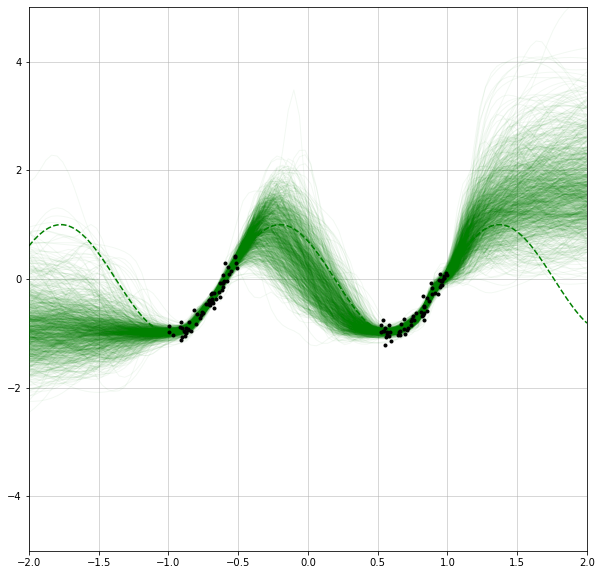

In [36]:
%matplotlib inline
fig=setup.makePlot(T(GeN(1000)).detach(),device)
ax=fig.get_axes()[0]
linspace=torch.linspace(-2,2,200)
ax.plot(linspace, torch.cos(4.0*(linspace+0.2)),'--', color='green')


# Results on test #

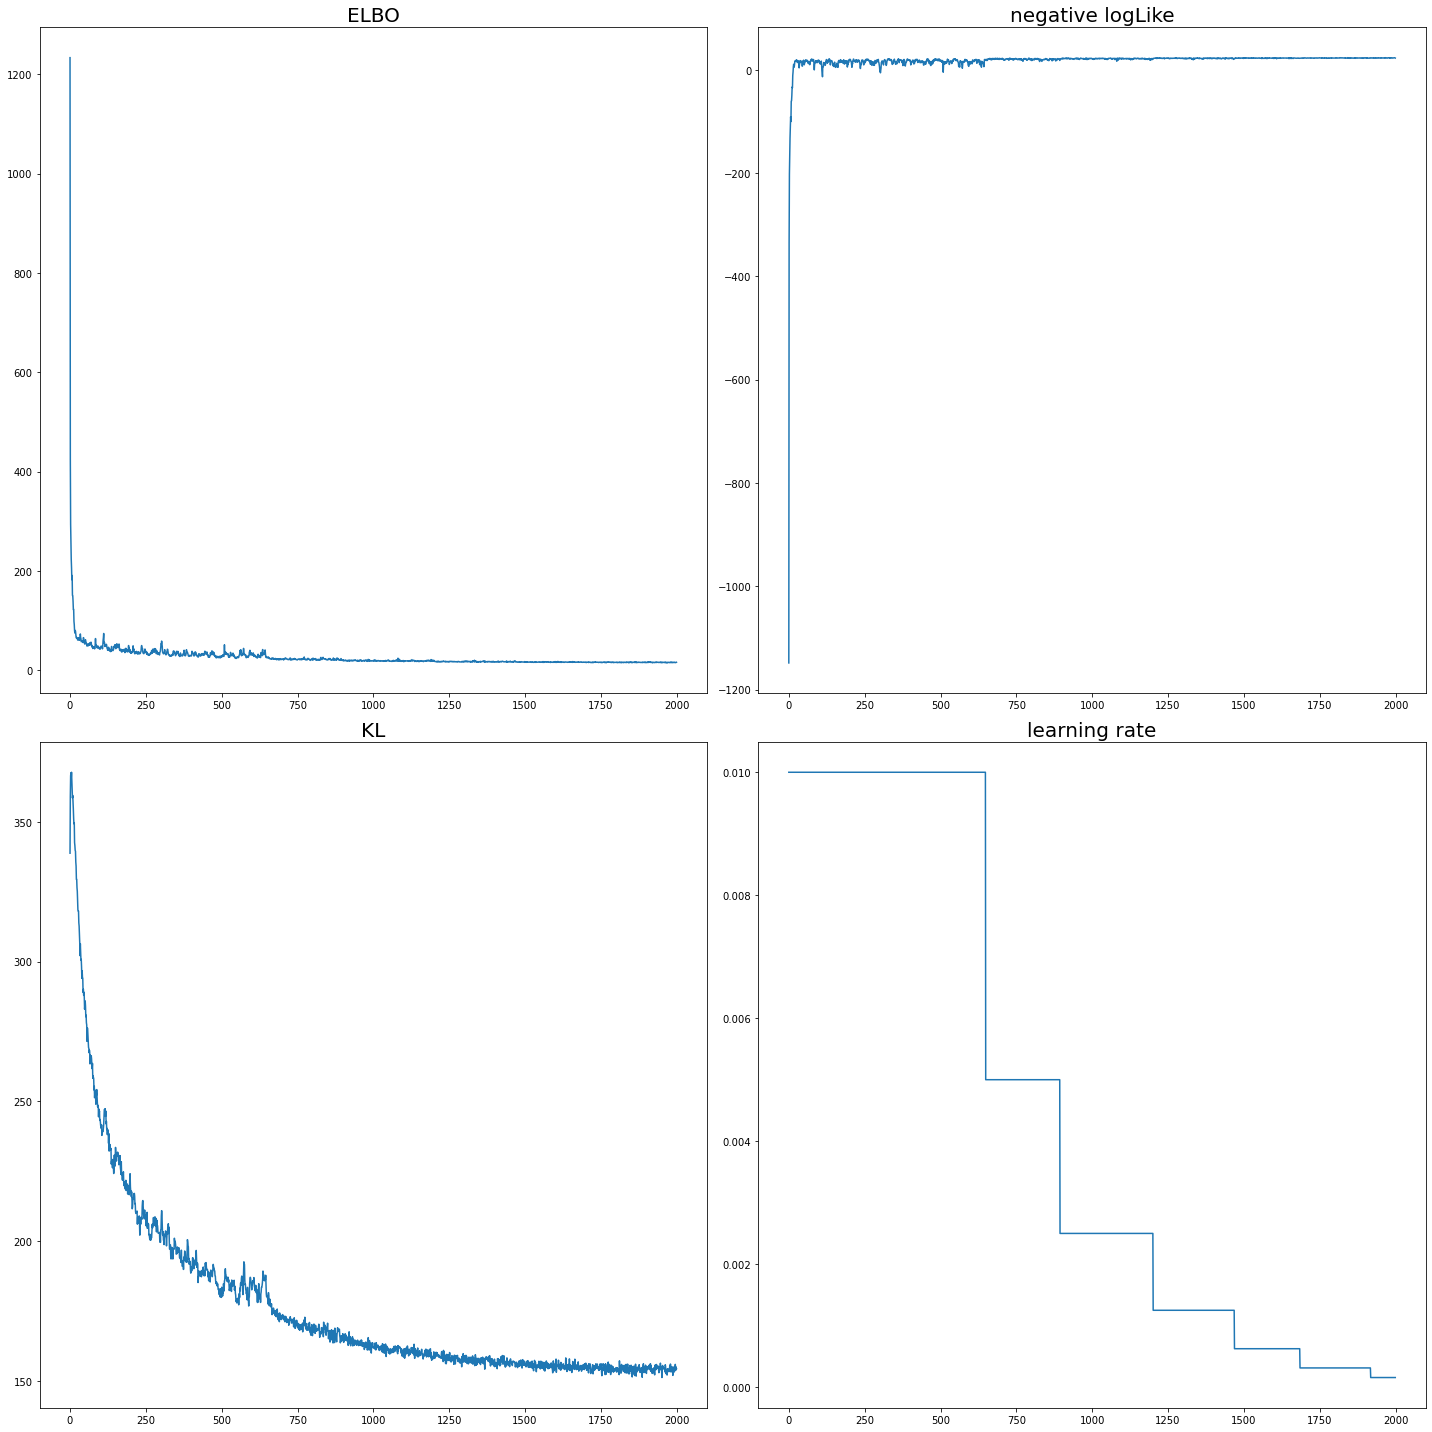

In [37]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs, 'LL':LLs}
time_line=torch.arange(0,len(training['ELBO']),1)

ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LR_=torch.as_tensor(training['LR'])
LL_=torch.as_tensor(training['LL'])

fig, ax =plt.subplots(2,2, figsize=(20,20))
ax[0,0].plot(time_line,ELBO_)
ax[0,0].set_title('ELBO', fontsize=20)
ax[0,1].plot(time_line,LL_)
ax[0,1].set_title('negative logLike', fontsize=20)
ax[1,0].plot(time_line,KL_)
ax[1,0].set_title('KL', fontsize=20)
ax[1,1].plot(time_line,LR_)
ax[1,1].set_title('learning rate', fontsize=20)
fig.tight_layout()

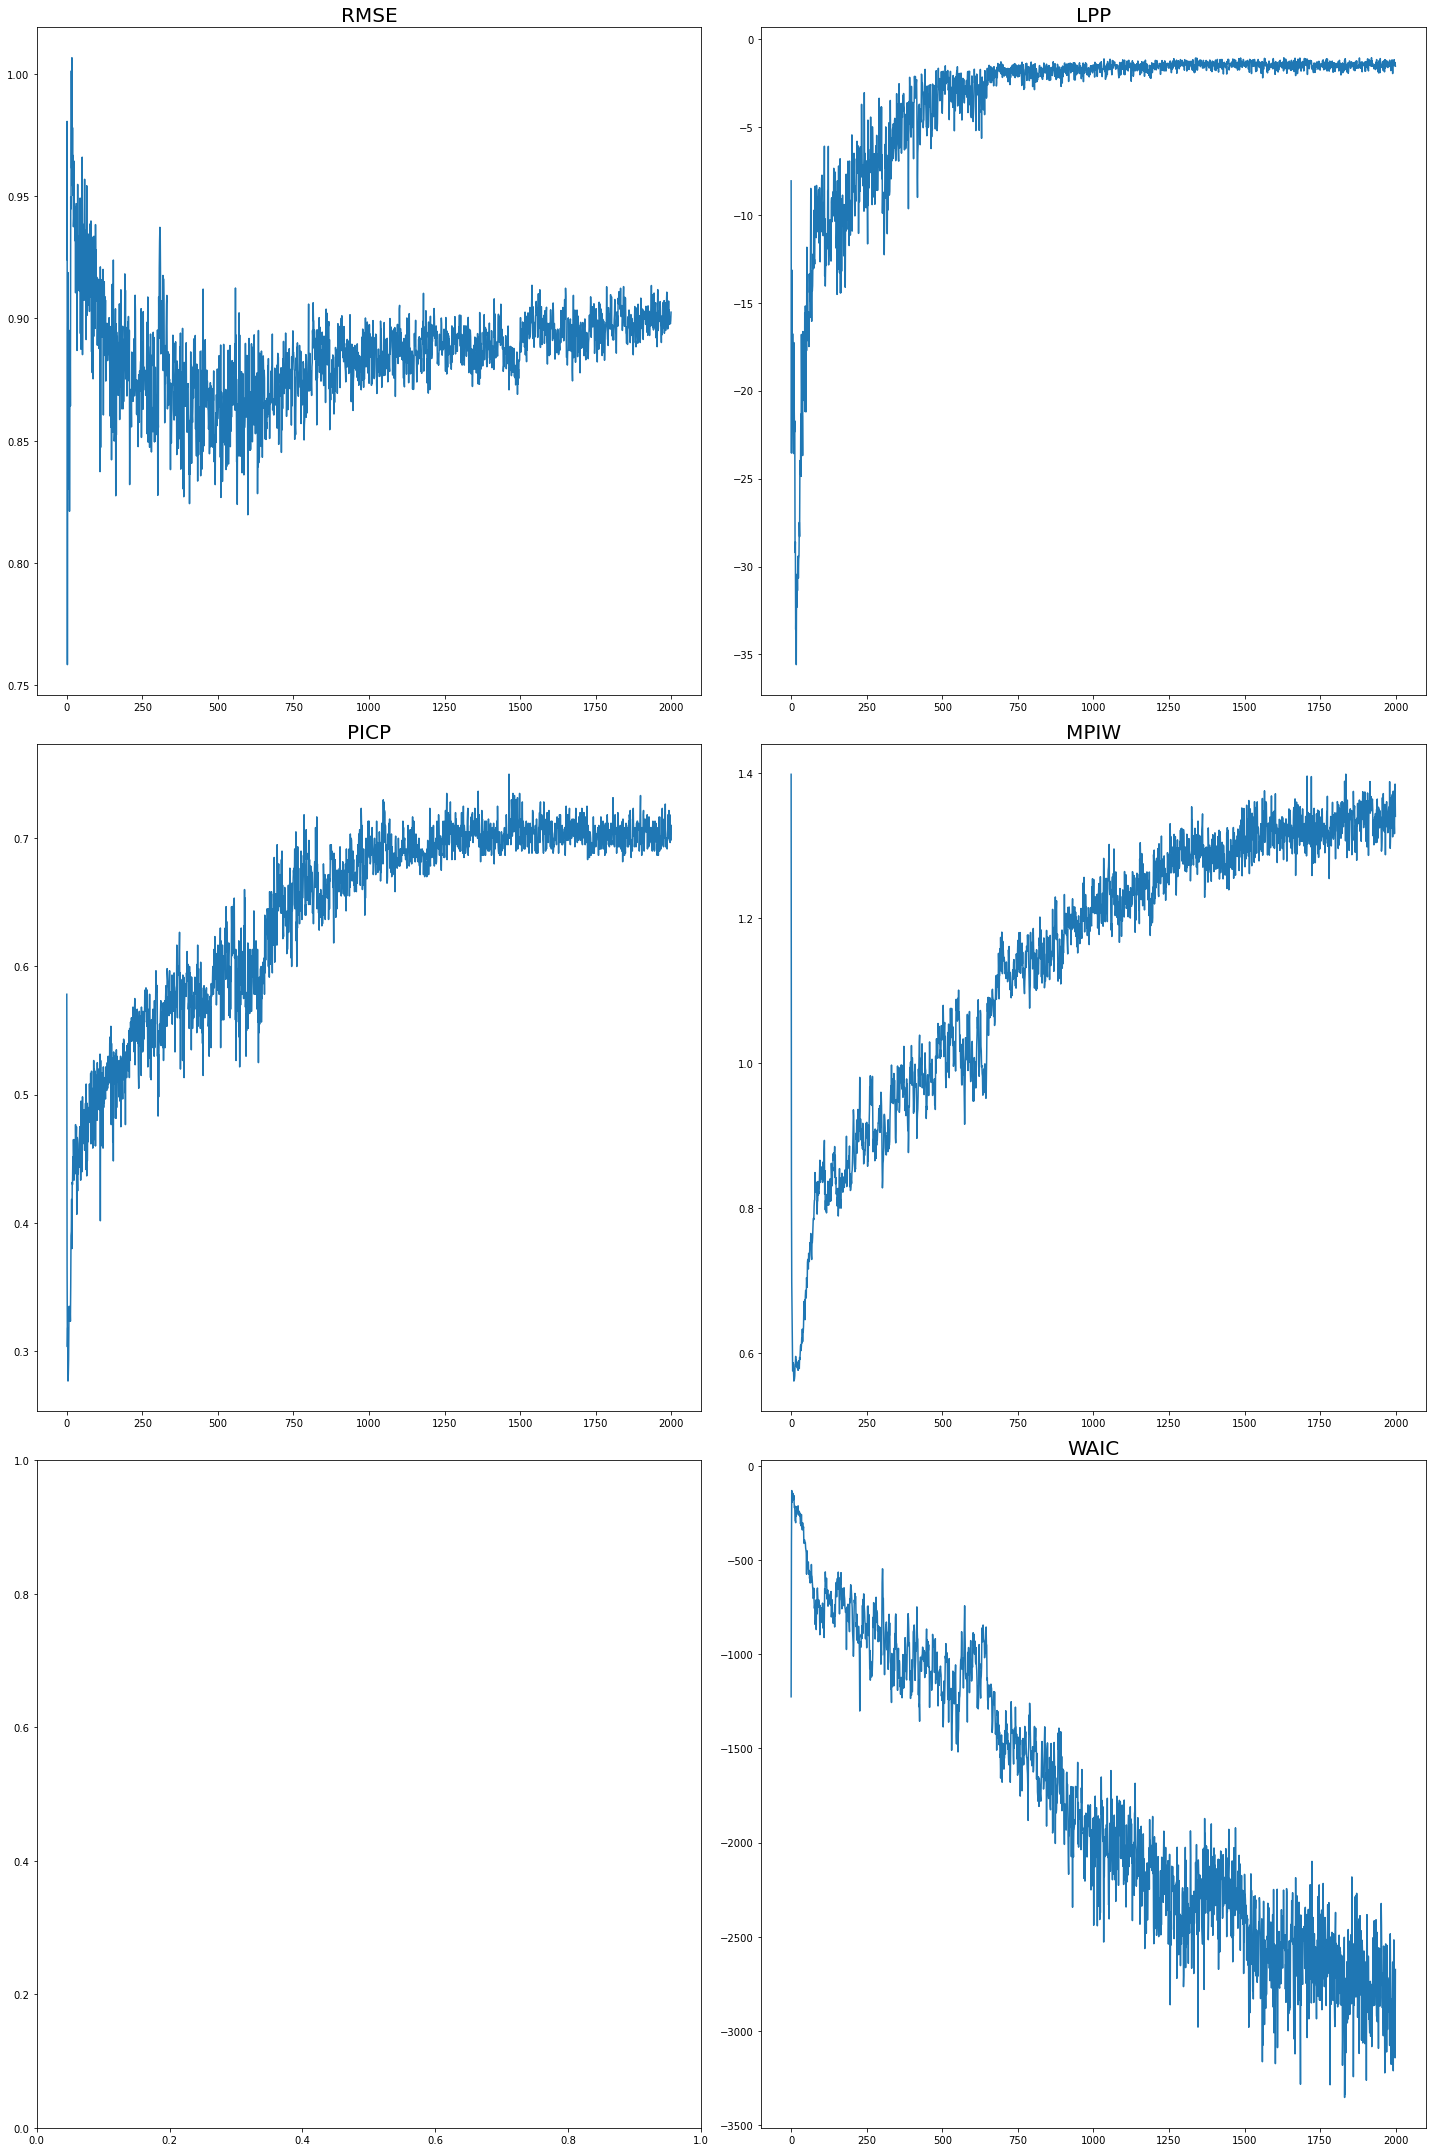

In [38]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(3,2, figsize=(20,30))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m, fontsize=20)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m, fontsize=20)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m, fontsize=20)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m, fontsize=20)
m='WAIC'
ax[2,1].plot(time_line,test_metrics[m])
ax[2,1].set_title(m, fontsize=20)

fig.tight_layout()

# Uncertainty vs error #

In [39]:
from torch.distributions import Uniform

sigma_noise_data = torch.tensor(0.1)
N = 25
M=100

X_l=Uniform(torch.tensor([-1.0]), torch.tensor([-.5])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r=Uniform(torch.tensor([.5]), torch.tensor([1.0])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_in=torch.cat([X_l,X_r]).to(device)
X_middle=Uniform(torch.tensor([-.5]), torch.tensor([.5])).sample(sample_shape=torch.Size([int(200)])).squeeze().to(device)
X_l_=Uniform(torch.tensor([-2.0]), torch.tensor([-1.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r_=Uniform(torch.tensor([1.]), torch.tensor([2.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_out=torch.cat([X_l_,X_r_]).to(device)

def f(X):
    y_ = torch.cos(4.0*(X+0.2)) 
    return y_ + sigma_noise_data* torch.randn_like(y_)

y_in=f(X_in).unsqueeze(-1)
y_middle=f(X_middle).unsqueeze(-1)
y_out=f(X_out).unsqueeze(-1)
print(X_in.shape, y_in.shape)

torch.Size([200]) torch.Size([200, 1])


Text(0.5, 0, 'Uncertainty (Diff Entropy)')

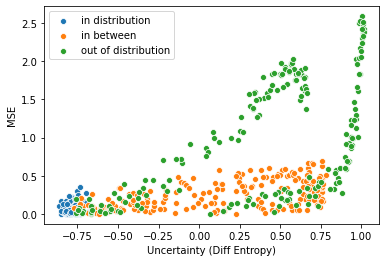

In [40]:
import seaborn as sns

X=[X_in,X_middle,X_out]
y=[y_in,y_middle,y_out]
label=['in distribution', 'in between', 'out of distribution']
def Entropy(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x NbExemples X NbDimensions
        k (Int): ordinal number

    Returns:
        Tensor: H of size Batch x 1, k-Nearest Neighbour Estimation of the entropy of theta, H[b]=H(theta[b]).

    """
    batch=theta.shape[0]
    nb_samples=theta.shape[1]
    d=torch.tensor(theta.shape[-1]).float()
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=1, largest=False, sorted=True)[0][:,k].to(device) #.clamp(torch.finfo().eps,float('inf'))    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    K_MC=torch.as_tensor(float(k_MC), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*torch.log(a).sum(1)


Hs=[]
AEs=[]
for i in range(len(X)):
    theta=T(GeN(1000)).detach()
    pred_=model(X[i],theta)
    pred=pred_+sigma_noise*torch.randn_like(pred_)

    M = pred.shape[0]
    M_low = int(0.025 * M)
    M_high = int(0.975 * M)

    y_pred_s, _ = pred_.sort(dim=0)

    y_low = y_pred_s[M_low, :].squeeze().to(device)
    y_high = y_pred_s[M_high, :].squeeze().to(device)

    PIW=(std_y_train*(y_high-y_low))


    H=(Entropy(pred.transpose(0,1),k=20))
    Hs.append(H)
    
    STD=(pred.std(0).squeeze())
    pred=model(X[i],theta)
    marginal_se=(pred-y[i])**2
    empirical_sqloss=marginal_se.mean()
    MSE=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze())**2)
    L1error=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze()).abs())
    AEs.append(L1error)
    ax=sns.scatterplot(H.cpu().numpy(),L1error.cpu().numpy(), label=label[i])
    
ax.set_ylabel('MSE')
ax.set_xlabel('Uncertainty (Diff Entropy)')



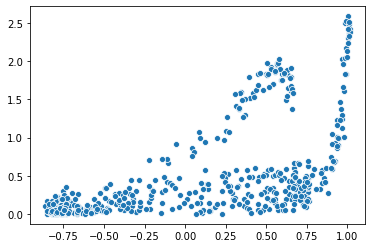

In [41]:
H_=torch.cat(Hs)
AE_=torch.cat(AEs)
sns.scatterplot(H_.cpu(),AE_.cpu())